<a href="https://colab.research.google.com/github/Tkag0001/AI_and_Machine_Learning_for_Coders/blob/main/Chapter3_3_Going_Beyond_the_Basics_Detecting_Features_in_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Going Beyond the Basics: Detecting Features in Images
Hi, chào mọi người. Như trên tựa đề đã ghi, ở chương này, tụi mình sẽ đi xa hơn nữa, hơn cả mức cơ bản. Tìm hiểu sâu hơn với khác niệm mới trong mạng thần kinh.

<img src="https://gregorygundersen.com/image/cnns/41847277995.png" alt="Description" style="width:30%;">

Chương này khá dài nên mình sẽ tổng quan trước những cái mới mà chúng mình sẽ học nha:

1. Cách sử dụng **phương pháp tích chập** để trích xuất các **đặc trưng** trong ảnh. Thông qua đó ta hiểu được cách sử dụng các **lớp tích chập (Convolution layer)** để tăng hiệu quả học các bức ảnh. Thêm đó là phần **lớp gộp(Pooling layer)** giúp giảm thiểu số lượng tính toán, tuy nhiên vẫn giữ được các đặc trưng chính.
2. Phương pháp **gia tăng thêm dữ liệu (augmentation)** giúp làm giàu kho dữ liệu hơn, tăng dữ liệu trong quá trình huấn luyện giúp cải thiện mô hình.
3. Phương pháp **học chuyển giao (transfer learning)** giúp mô hình có thể tận dụng lại những kiến thức đã học được trước đó.
4. Ngoài ra chúng mình cũng sẽ ôn lại về **phân loại đa lớp (multi classification)** cũng như tìm hiểu sơ qua về phương pháp **loại bỏ ngẫu nhiên (dropout)** giúp cải thiện mô hình, tránh được tình trạng **quá khớp (overfitting)**.

*Lưu ý: Khuyến khích mọi người sử dụng Colab hãy chuyển sang T4 GPU ở chương này nha vì việc huấn luyện mô hình sử dụng các lớp tích chập tốn khá nhiều thời gian tính toán.*

# 3. Tụi mình sẽ đến với một khái niệm mới là học chuyển giao (transfer learning)

Hiểu đơn giản là vầy, từ trước đến giờ mình toàn huấn luyện một mô hình từ đầu đến cuối. Còn bây giờ, tụi mình sẽ sử dụng một mô hình đã được huấn luyện sẵn trước đó và tiếp tục huấn luyện trên dữ liệu của mình, từ đó mô hình học được nhiều hơn và có thể đưa ra kết quả tốt hơn.

Về cách triển khai, ở trong mô hình dưới đây, chúng ta sẽ triển khai theo kiểu tận dụng kiến trúc và trọng số của mô hình có sẵn và kết hợp thêm với các lớp tuyến tính của chúng ta để thu được đầu ra cuối cùng.

Về phần các lớp lấy từ mô hình có sẵn, tụi mình sẽ không huấn luyện chúng mà tiến hành đóng bằng hay khóa chúng lại, tức khi huấn luyện thì trọng số trong các lớp của mô hình có sẵn sẽ không bị thay đổi nữa. Chỉ có các lớp tuyến tính mà chúng ta định nghĩa thêm mới thay đổi và cập nhật trọng số.

------------------------------------------------------------------------------
Có rất nhiều mô hình đã được huấn luyện sẵn trước như các loại resnet,... Ở trong mô hình lần này tụi mình sẽ sử dụng mô hình **Inception version 3** tải từ **Keras** nha.

In [ ]:
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Tải trọng số  hay kiến thức học được của mô hình.
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"

urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7fab60b705b0>)

In [ ]:
# Khởi tạo mô hình InceptionV3 và nạp trọng số vào cho mô hình
# Ở đây trong sách để kích thước là 150 x 150 nha, nhưng khi mình huấn luyện với bộ horse-or-human
# mình thấy kích thước 300 x 300 mới huấn luyện được nên đổi lại.
pre_trained_model = InceptionV3(input_shape=(300, 300, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(weights_file)

Tụi mình sẽ thử xem qua kiến trúc của mô hình nha.

P/S: Mình nghĩ là không nên xem thì hơn, xem vào hoảng loạn thêm (0_0)

In [ ]:
# Xem qua kiến trúc của mô hình.
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 149, 149, 32)   │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 149, 149, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 147, 147, 32)   │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 147, 147, 64)   │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 147, 147, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 73, 73, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 73, 73, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 73, 73, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

### Tập trung kỹ phần trích xuất, chọn lớp này nha mọi người.
Ở đây theo như tác giả trong sách đề xuất thì tụi mình sẽ sử dụng đầu ra ở lớp **mixed7** nha, mọi người có thể tìm thấy nó ở cột đầu tiên. Đầu ra sẽ là hình ảnh với kích thước **7 x 7**.

Về việc có thể chọn các lớp khác không thì tất nhiên là thoải mái nha, mọi người cứ tự do khám phá và kết hợp rồi tìm ra cái nào hiệu quả nhất với mình là được. Mọi người có thể thử lập một bảng so sánh kết quả huấn luyện các mô hình khác nhau xem.

Sau khi xác định được vị trí hay lớp mà chúng ta muốn trích xuất đầu ra thì tụi mình sẽ tiến hành đóng băng hết tất cả các lớp của mô hình **InceptionV3**, không cho chúng học trong quá trình huấn luyện và chỉ định lớp chúng ta chọn nha.

In [ ]:
# Tiến hành đóng băng các lớp của mô hình InceptionV3
for layer in pre_trained_model.layers:
    layer.trainable = False

# Chọn lớp trích xuất đầu ra cuối
last_layer = pre_trained_model.get_layer('mixed7')
print(f"Kích thước đầu ra của lớp đã chọn: {last_layer.output.shape}")

# Định nghĩa đầu ra cuối cùng
last_output = last_layer.output

Kích thước đầu ra của lớp đã chọn: (None, 17, 17, 768)


Bây giờ tụi mình sẽ tiến hành kết hợp đầu ra lớp trích xuất cuối được chọn từ mô hình **InceptionV3** với các lớp tuyến tính để cho ra đầu ra dự đoán cuối cùng của mô hình mình nha

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Trải phẳng hình ảnh hay ma trận đặc trưng thu được từ việc trích xuất lớp cuối để đưa vào lớp tuyến tính
x = Flatten()(last_output)
# Thêm các lớp tuyến tính vào và cho dữ liệu thu được (x) đi qua
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

Vậy là hoàn thành quá trình chuẩn bị rồi, bây giờ tụi mình khởi tạo mô hình với đầu vào là của mô hình được huấn luyện sẵn **(InceptionV3)** và **kiến trúc x (quá trình đi qua các lớp)** mà chúng ta đã định nghĩa ở trên nha.

In [ ]:
from tensorflow.keras.optimizers import RMSprop
# Khởi tạo mô hình
model = Model(pre_trained_model.input, x)

# Định nghĩa các tham số
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [ ]:
# Tụi mình sẽ huấn luyện mô hình với số lượng epochs là 40 nha
# Lưu ý: ở đây mình đang sử dụng tập dữ liệu sau khi qua bước Image augmentation nha, mọi người sử dụng tập dữ liệu gốc cũng được
history = model.fit(
    train_generator,
    epochs=40,
    validation_data = validation_generator
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 950ms/step - acc: 0.7471 - loss: 1.1630 - val_acc: 0.9727 - val_loss: 0.0774
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 675ms/step - acc: 0.9222 - loss: 0.3378 - val_acc: 0.9727 - val_loss: 0.0740
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 657ms/step - acc: 0.9979 - loss: 0.0088 - val_acc: 0.9492 - val_loss: 0.1794
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 682ms/step - acc: 0.9937 - loss: 0.0175 - val_acc: 0.9727 - val_loss: 0.0824
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 684ms/step - acc: 0.9942 - loss: 0.0122 - val_acc: 0.9648 - val_loss: 0.1509
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 657ms/step - acc: 0.9990 - loss: 0.0042 - val_acc: 0.9531 - val_loss: 0.1661
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 693ms/step - acc: 0.9985 - loss: 0.0029 - val_acc: 0.9375 - val_loss: 0.3294
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - acc: 1.0000 - loss: 0.0014 - val_acc: 0.9453 - val_loss: 0.2829
Epoch 9/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 686ms/step - acc:

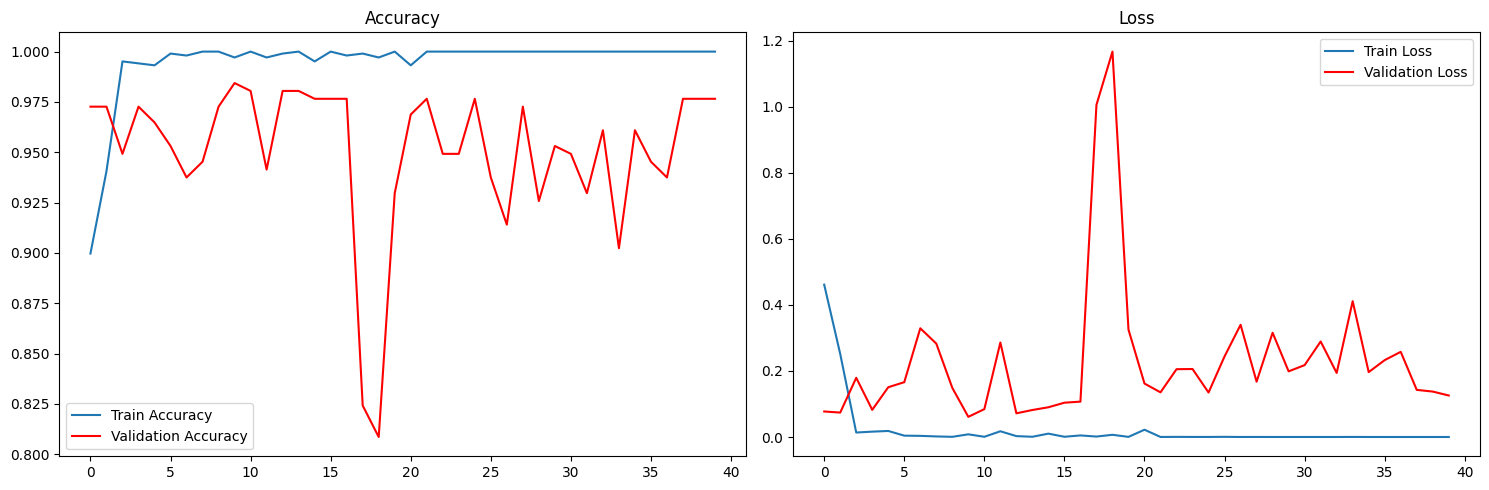

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ đánh giá quá trình train trên 15 epochs
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy', color = 'red')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss', color = 'red')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Kết quả đánh giá trên tập val
result = model.evaluate(validation_generator)
for i,m in enumerate(model.metrics_names):
  print(f"Kết quả đánh giá {m} trên tập val: {result[i]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - acc: 0.9649 - loss: 0.1801
Kết quả đánh giá loss trên tập val: 0.12572461366653442
Kết quả đánh giá compile_metrics trên tập val: 0.9765625


### Kết quả ở lần chạy của mình đây nha

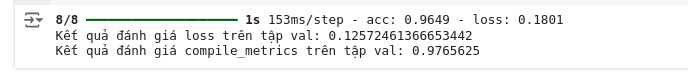

Đáng kinh ngạc ha mọi người, một con số quá ấn tượng khi mà tăng hẳn lên 97%.

Qua đó ta có thể thấy được việc tận dụng lại kiến trúc và kiến thức sẵn có từ các mô hình có sẵn sẽ tốt hơn rất nhiều. Tuy nhiên lưu ý đôi khi việc lạm dụng kiến trúc quá sâu có thể dẫn đến việc quá khớp khiến sai sót kết quả dự đoán trên dữ liệu thực tế.

Ở đây mọi người có thể thử kiểm tra lại kết quả dự đoán của mô hình bằng cách tải các ảnh thực tế lên để xem xét.

*Lưu ý: khi huấn luyện cũng như đánh giá một mô hình, hãy kiểm tra thêm các yếu tố về dữ liệu huấn luyện. Bộ dữ liệu **horse-or-human** hiện tại chúng ta dùng đều là các **ảnh sinh ra từ máy tính**, nên có thể khi đánh giá mô hình trên ảnh thực tế, kết quả sẽ không khả quan lắm.*

### Bài tập luyện tập
- Mọi người có thể thử xây dựng lại mô hình học chuyển giao này với bộ dữ liệu rộng hơn như [**Dogs vs. Cats** ](https://www.kaggle.com/c/dogs-vs-cats/data). Trong này hình ảnh về chó mèo đều là hình ảnh thực tế nên có thể kiểm tra với các ảnh chó mèo chụp ngoài đời thật hiệu quả hơn.
- Mọi người có thể thử kết hợp với nhiều mô hình có sẵn khác ngoài **InceptionV3** kể trên.

### Tổng kết về học chuyển giao.
- Là qúa trình sử dụng lại kiến trúc cũng như trọng số của mô hình cũ để kết hợp với lớp đầu ra mới, qua đó tận dụng được kiến thức mô hình cũ và tăng độ hiệu quả cao hơn.
- Cách thức thực hiện: cập nhật trọng số mô hình có sẵn -> đóng băng lại trọng số các lớp trên mô hình có sẵn -> chọn lớp nào làm lớp cuối để trích xuất đầu ra từ mô hình có sẵn -> kết hợp với các lớp mới và lớp kết nối đầy đủ -> huấn luyện mô hình.